## Ejercicio 1
En este primer bloque de código vamos a implementar la QFT y la AQFT con 2 rotaciones máximo. 

Los 2 primeros métodos son QFT y AQFT para 4 qubits, incluyendo siempre los swaps finales. Los 2 siguientes métodos son generalizaciones de estos métodos para $n$ qubits y con un parámetro booleano para activar o no la aplicación de los swaps finales. Además, se añade otro parámetro al método para la AQFT que restringe el número de rotaciones a un valor que se le pasa por parámetro.

Además, se han creado unas funciones de QFT y AQFT inversa para poder hacer el sumador de Drapper en el segundo apartado.

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister
import numpy as np
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# Implementamos la funcion para hacer una QFT de 4 qubits
def qft_4(circuit):
    n = 4
    for i in range(n):
        circuit.h(n-i-1)
        for j in range(i+1, n):
            circuit.cp(np.pi / 2**(j-i), n-j-1, n-i-1)
    
    # Swap qubits to reverse the order
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    
    return circuit

# Implementamos la funcion para hacer una AQFT de 4 qubits con 2 rotaciones como maximo
def aqft_4(circuit):
    n = 4
    for i in range(n):
        circuit.h(n-i-1)
        for j in range(i+1, n):
            if j-i <= 2:
                circuit.cp(np.pi / 2**(j-i), n-j-1, n-i-1)
    
    # Swap qubits to reverse the order
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    return circuit

def qft(circuit, n, toggle_swap = True):
    for i in range(n):
        circuit.h(n-i-1)
        for j in range(i+1, n):
            circuit.cp(np.pi / 2**(j-i), n-j-1, n-i-1)
    if toggle_swap:
        # Swap qubits to reverse the order
        for i in range(n//2):
            circuit.swap(i, n-i-1)
    return circuit

def aqft(circuit, n, max_rotations = 2, toggle_swap = True):
    for i in range(n):
        circuit.h(n-i-1)
        for j in range(i+1, n):
            if j-i <= max_rotations:
                circuit.cp(np.pi / 2**(j-i), n-j-1, n-i-1)
    
    if toggle_swap:
        # Swap qubits to reverse the order
        for i in range(n//2):
            circuit.swap(i, n-i-1)
    return circuit

# Inverse qft
def iqft(circuit, n, toggle_swap = True):
    qft_circ = qft(QuantumCircuit(n), n, toggle_swap)
    inverse_circ = qft_circ.inverse()
    circuit.append(inverse_circ, circuit.qubits[:n])
    return circuit

# Inverse aqft
def iaqft(circuit, n, max_rotations = 2, toggle_swap = True):
    aqft_circ = aqft(QuantumCircuit(n), n, max_rotations, toggle_swap)
    inverse_circ = aqft_circ.inverse()
    circuit.append(inverse_circ, circuit.qubits[:n])
    return circuit

# Creamos el circuito cuantico
qreg = QuantumRegister(4, name='q')
circ2 = QuantumCircuit(qreg)

## Ejercicio 2

En el primer bloque de código vamos a hacer una sumador de Drapper usando una QFT y en el segundo vamos a usar una AQFT con 2 rotaciones como máximo.

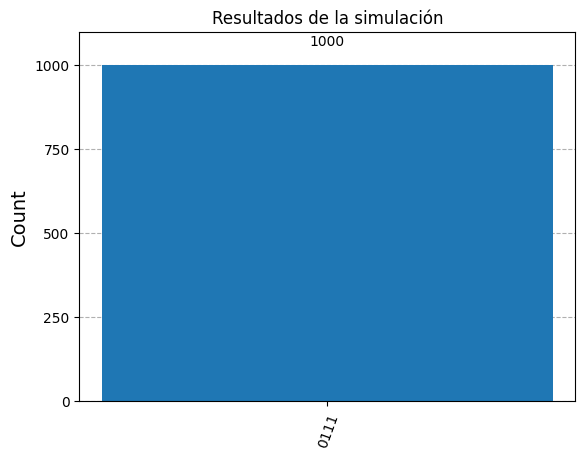

In [14]:
# Creamos el circuito 
qreg = QuantumRegister(4, name='q')
creg = ClassicalRegister(4, name='c')
circ = QuantumCircuit(qreg, creg)

# Inicializamos el circuito con A = 10 y B = 01
circ.x(qreg[1])
circ.x(qreg[2])

# Aplicamos la QFT a los qubits q0 y q1
circ = qft(circ, 2, toggle_swap=False)

# Aplicamos la las rotaciones controladas de B a A
for i in range(2):
    for j in range(i + 1):
        circ.cp(np.pi / 2**(i-j), qreg[j + 2], qreg[i])

# Aplicamos la QFT inversa a los qubits q0 y q1
circ = iqft(circ, 2, toggle_swap=False)

# Medimos los qubits
circ.measure(qreg, creg)

# Lanzamos el circuito en el simulador
backend = Aer.get_backend('qasm_simulator')
shots = 1000
compiled_circuit = transpile(circ, backend)
job = backend.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()
# Mostramos el histograma
plot_histogram(counts, title='Resultados de la simulación')

En los resultados podemos ver que en simulación sin ruido da un resultado perfecto. En los qubits $q_0$ y $q_1$ obtenemos el resultado de hacer 
$$
A + B 
\rightarrow 10 + 01
= 11 \\
\therefore q_0, q_1 = A + B
$$

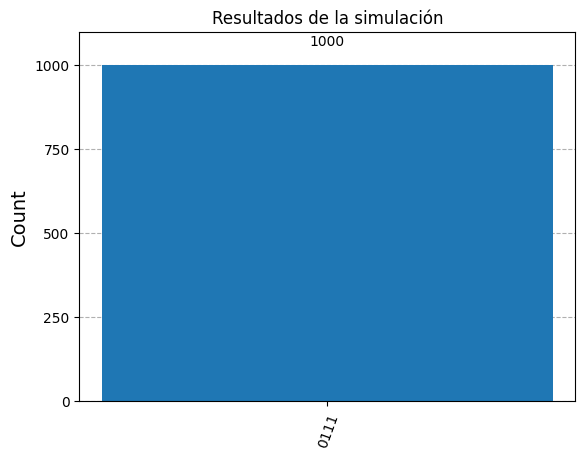

In [13]:
# Creamos el circuito 
qreg = QuantumRegister(4, name='q')
creg = ClassicalRegister(4, name='c')
circ2 = QuantumCircuit(qreg, creg)

# Inicializamos el circuito con A = 10 y B = 01
circ2.x(qreg[1])
circ2.x(qreg[2])

# Aplicamos la AQFT a los qubits q0 y q1
circ2 = aqft(circ2, 2, max_rotations=2, toggle_swap=False)

# Aplicamos la las rotaciones controladas de B a A
for i in range(2):
    for j in range(i + 1):
        circ2.cp(np.pi / 2**(i-j), qreg[j + 2], qreg[i])

# Aplicamos la AQFT inversa a los qubits q0, q1
circ2 = iaqft(circ2, 2, max_rotations=2, toggle_swap=False)

# Medimos los qubits
circ2.measure(qreg, creg)

# Lanzamos el circuito en el simulador
backend = Aer.get_backend('qasm_simulator')
shots = 1000
compiled_circuit = transpile(circ2, backend)
job = backend.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()
# Mostramos el histograma
plot_histogram(counts, title='Resultados de la simulación')

La simulación con la QFT aproximada da los mismos resultados que la simulación que usa la QFT.

Esto se debe a que con nuestro número de qubits las rotaciones que se hacen son prácticamente las mismas. También se ha probado a incrementar el número de qubits a 8 para ver si las diferencias entre la QFT y la AQFT serían observables con más qubits. No obstante, los resultados han seguido siendo iguales.

## Ejercicio 3

Lanzamos el sumador de Draper a un backend real. El primer bloque de código corresponde al circuito con la QFT y el segundo al sumador realizado con la AQFT.

job id: czmrrrk112c0008avwhg
PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-03-30 18:24:37', stop='2025-03-30 18:24:38', size=1000>)])}, 'version': 2})
{'0110': 12, '1111': 28, '0111': 808, '0011': 60, '0100': 8, '0101': 30, '1001': 2, '0001': 37, '0000': 1, '1011': 4, '0010': 6, '1101': 4}


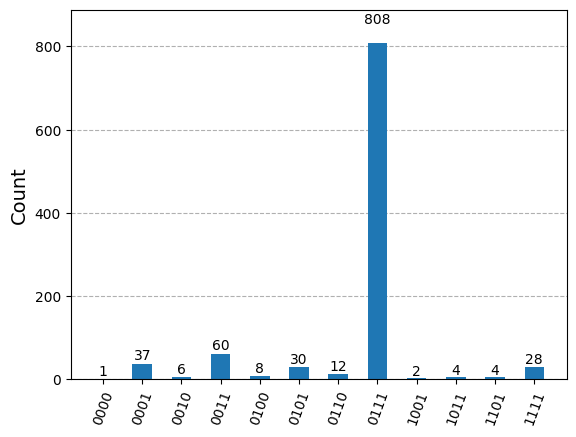

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Auth token for IBM Quantum
token = ""

# Ejecutamos en un backend real
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(circ)

isa_circuit.draw("mpl", idle_wires=False)

sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=1000)
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

# Mostramos resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))


job id: czmrsjyp3xeg008hbwr0
PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1000, num_bits=4>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-03-30 18:26:25', stop='2025-03-30 18:26:26', size=1000>)])}, 'version': 2})
{'0000': 2, '0111': 800, '0011': 45, '1111': 43, '0100': 14, '0001': 32, '0101': 33, '1101': 7, '0010': 7, '0110': 14, '1011': 3}


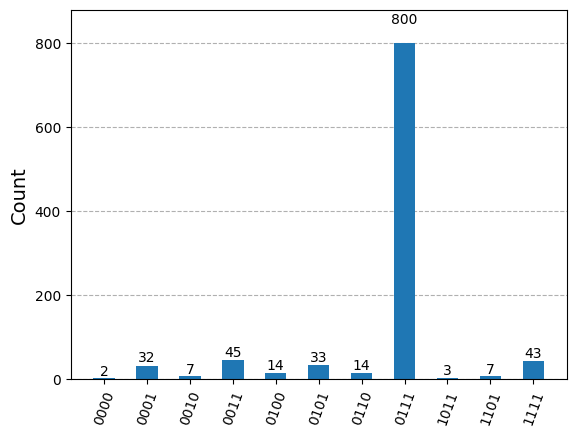

In [22]:
# Ejecutamos en un backend real
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

backend = service.least_busy(simulator=False, operational=True)

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)

isa_circuit2 = pm.run(circ2)

isa_circuit2.draw("mpl", idle_wires=False)

sampler = Sampler(backend)
job = sampler.run([isa_circuit2], shots=1000)
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

# Mostramos resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))


Se puede observar que los resultados son similares y que en ambos casos, tanto en la QFT como en la AQFT se pueden ver errores. Cabe resaltar que se han eliminado las barreras que se habían puesto en los circuitos para mayor claridad ya que esto provocaba que diera muchos más errores y los resultados fueran prácticamente inservibles.

En un principio pensé que la QFT tendría menos errores que la AQFT ya que se hacen menos rotaciones y se obvian algunos ángulos. No obstante, he estado mirando y parece que en ordenadores cuánticos reales el hecho de tener menos puertas hace que haya menos decoherencia. Por lo tanto, la reducción en puertas hace que la decoherencia disminuya y así no haya tanto error.